In [1]:
import sys

from data_helper import ImageGenerator, get_train_matrices, get_test_matrices
from sklearn.cross_validation import train_test_split
from keras_helper import KerasModel
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from itertools import chain

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.
/home/westside/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
img_size = (192, 192)
img_channels = 3
output_size = 17

In [3]:
X_train, y_train, labels_map = get_train_matrices("../data/train_v2.csv", "../data/train-jpg", img_size)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
gc.collect()

100%|██████████| 40479/40479 [02:20<00:00, 287.64it/s]


7

In [4]:
generator = ImageGenerator()
flow = generator.get_train_generator(X_train, y_train, batch_size=32)
validation_data = (X_valid, y_valid)

In [5]:
from tensorflow.contrib.keras.api.keras.callbacks import ModelCheckpoint

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

In [6]:
model = KerasModel(img_size)
learn_rates = [0.001, 0.0001, 0.00001, 0.000001]
epochs_list = [30, 20, 10, 5]
train_losses, val_losses = [], []

for lr, epochs in zip(learn_rates, epochs_list):
    tmp_train_losses, tmp_val_losses, fbeta_score = model.fit(flow, epochs, lr, (X_valid, y_valid), train_callbacks=[checkpoint], batches=3500)
    train_losses += tmp_train_losses
    val_losses += tmp_val_losses

Epoch 1/30
3500/3500 [==============================] - 322s - loss: 0.2362 - acc: 0.9063 - val_loss: 0.1790 - val_acc: 0.9270
Epoch 2/30
3500/3500 [==============================] - 318s - loss: 0.1860 - acc: 0.9254 - val_loss: 0.1664 - val_acc: 0.9321
Epoch 3/30
3500/3500 [==============================] - 319s - loss: 0.1757 - acc: 0.9292 - val_loss: 0.1663 - val_acc: 0.9309
Epoch 4/30
3500/3500 [==============================] - 320s - loss: 0.1722 - acc: 0.9304 - val_loss: 0.1621 - val_acc: 0.9340
Epoch 5/30
3500/3500 [==============================] - 321s - loss: 0.1618 - acc: 0.9347 - val_loss: 0.1526 - val_acc: 0.9374
Epoch 6/30
3500/3500 [==============================] - 320s - loss: 0.1572 - acc: 0.9368 - val_loss: 0.1453 - val_acc: 0.9401
Epoch 7/30
3500/3500 [==============================] - 321s - loss: 0.1524 - acc: 0.9388 - val_loss: 0.1464 - val_acc: 0.9402
Epoch 8/30
3500/3500 [==============================] - 321s - loss: 0.1482 - acc: 0.9409 - val_loss: 0.1397 - 

3500/3500 [==============================] - 322s - loss: 0.1034 - acc: 0.9603 - val_loss: 0.0985 - val_acc: 0.9623
Epoch 4/20
3500/3500 [==============================] - 322s - loss: 0.1028 - acc: 0.9605 - val_loss: 0.0986 - val_acc: 0.9619
Epoch 5/20
3500/3500 [==============================] - 322s - loss: 0.1027 - acc: 0.9606 - val_loss: 0.0984 - val_acc: 0.9624
Epoch 6/20
3500/3500 [==============================] - 322s - loss: 0.1023 - acc: 0.9607 - val_loss: 0.0982 - val_acc: 0.9625
Epoch 7/20
3500/3500 [==============================] - 322s - loss: 0.1023 - acc: 0.9607 - val_loss: 0.0980 - val_acc: 0.9624
Epoch 8/20
3500/3500 [==============================] - 322s - loss: 0.1021 - acc: 0.9608 - val_loss: 0.0979 - val_acc: 0.9626
Epoch 9/20
3500/3500 [==============================] - 322s - loss: 0.1015 - acc: 0.9612 - val_loss: 0.0979 - val_acc: 0.9626
Epoch 10/20
3500/3500 [==============================] - 322s - loss: 0.1015 - acc: 0.9610 - val_loss: 0.0976 - val_acc: 0

3500/3500 [==============================] - 322s - loss: 0.0989 - acc: 0.9621 - val_loss: 0.0971 - val_acc: 0.9630
Epoch 5/5
3500/3500 [==============================] - 322s - loss: 0.0988 - acc: 0.9621 - val_loss: 0.0970 - val_acc: 0.9631


In [7]:
model.load_weights("weights.best.hdf5")
print("Weights loaded")

Weights loaded


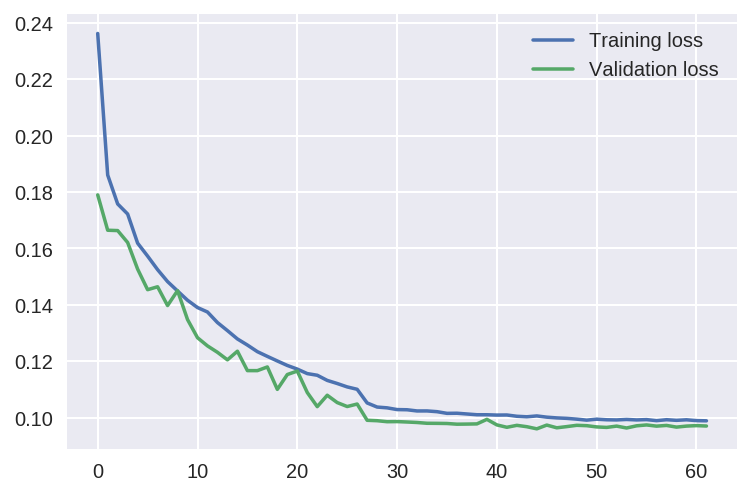

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

In [9]:
fbeta_score

0.91775847482242712

In [10]:
del X_train, y_train
gc.collect()

x_test, x_test_filename = get_test_matrices("../data/test-jpg", img_size)
# Predict the labels of our x_test images
predictions = model.predict(x_test)

del x_test
gc.collect()

x_test, x_test_filename_additional = get_test_matrices("../data/test-jpg-additional", img_size)
new_predictions = model.predict(x_test)

del x_test
gc.collect()

predictions = np.vstack((predictions, new_predictions))
x_test_filename = np.hstack((x_test_filename, x_test_filename_additional))
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              predictions[0]))

100%|██████████| 20522/20522 [02:20<00:00, 145.96it/s]


Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions entry:
[  1.32373711e-02   7.41808572e-06   4.46012389e-04   1.46079678e-02
   1.10508769e-03   9.96671438e-01   6.51347073e-05   4.58152863e-06
   4.80812136e-03   2.88874446e-03   2.86298501e-03   3.00711632e-04
   9.99754012e-01   6.08916441e-03   1.47165661e-03   5.18209963e-05
   7.37177115e-03]


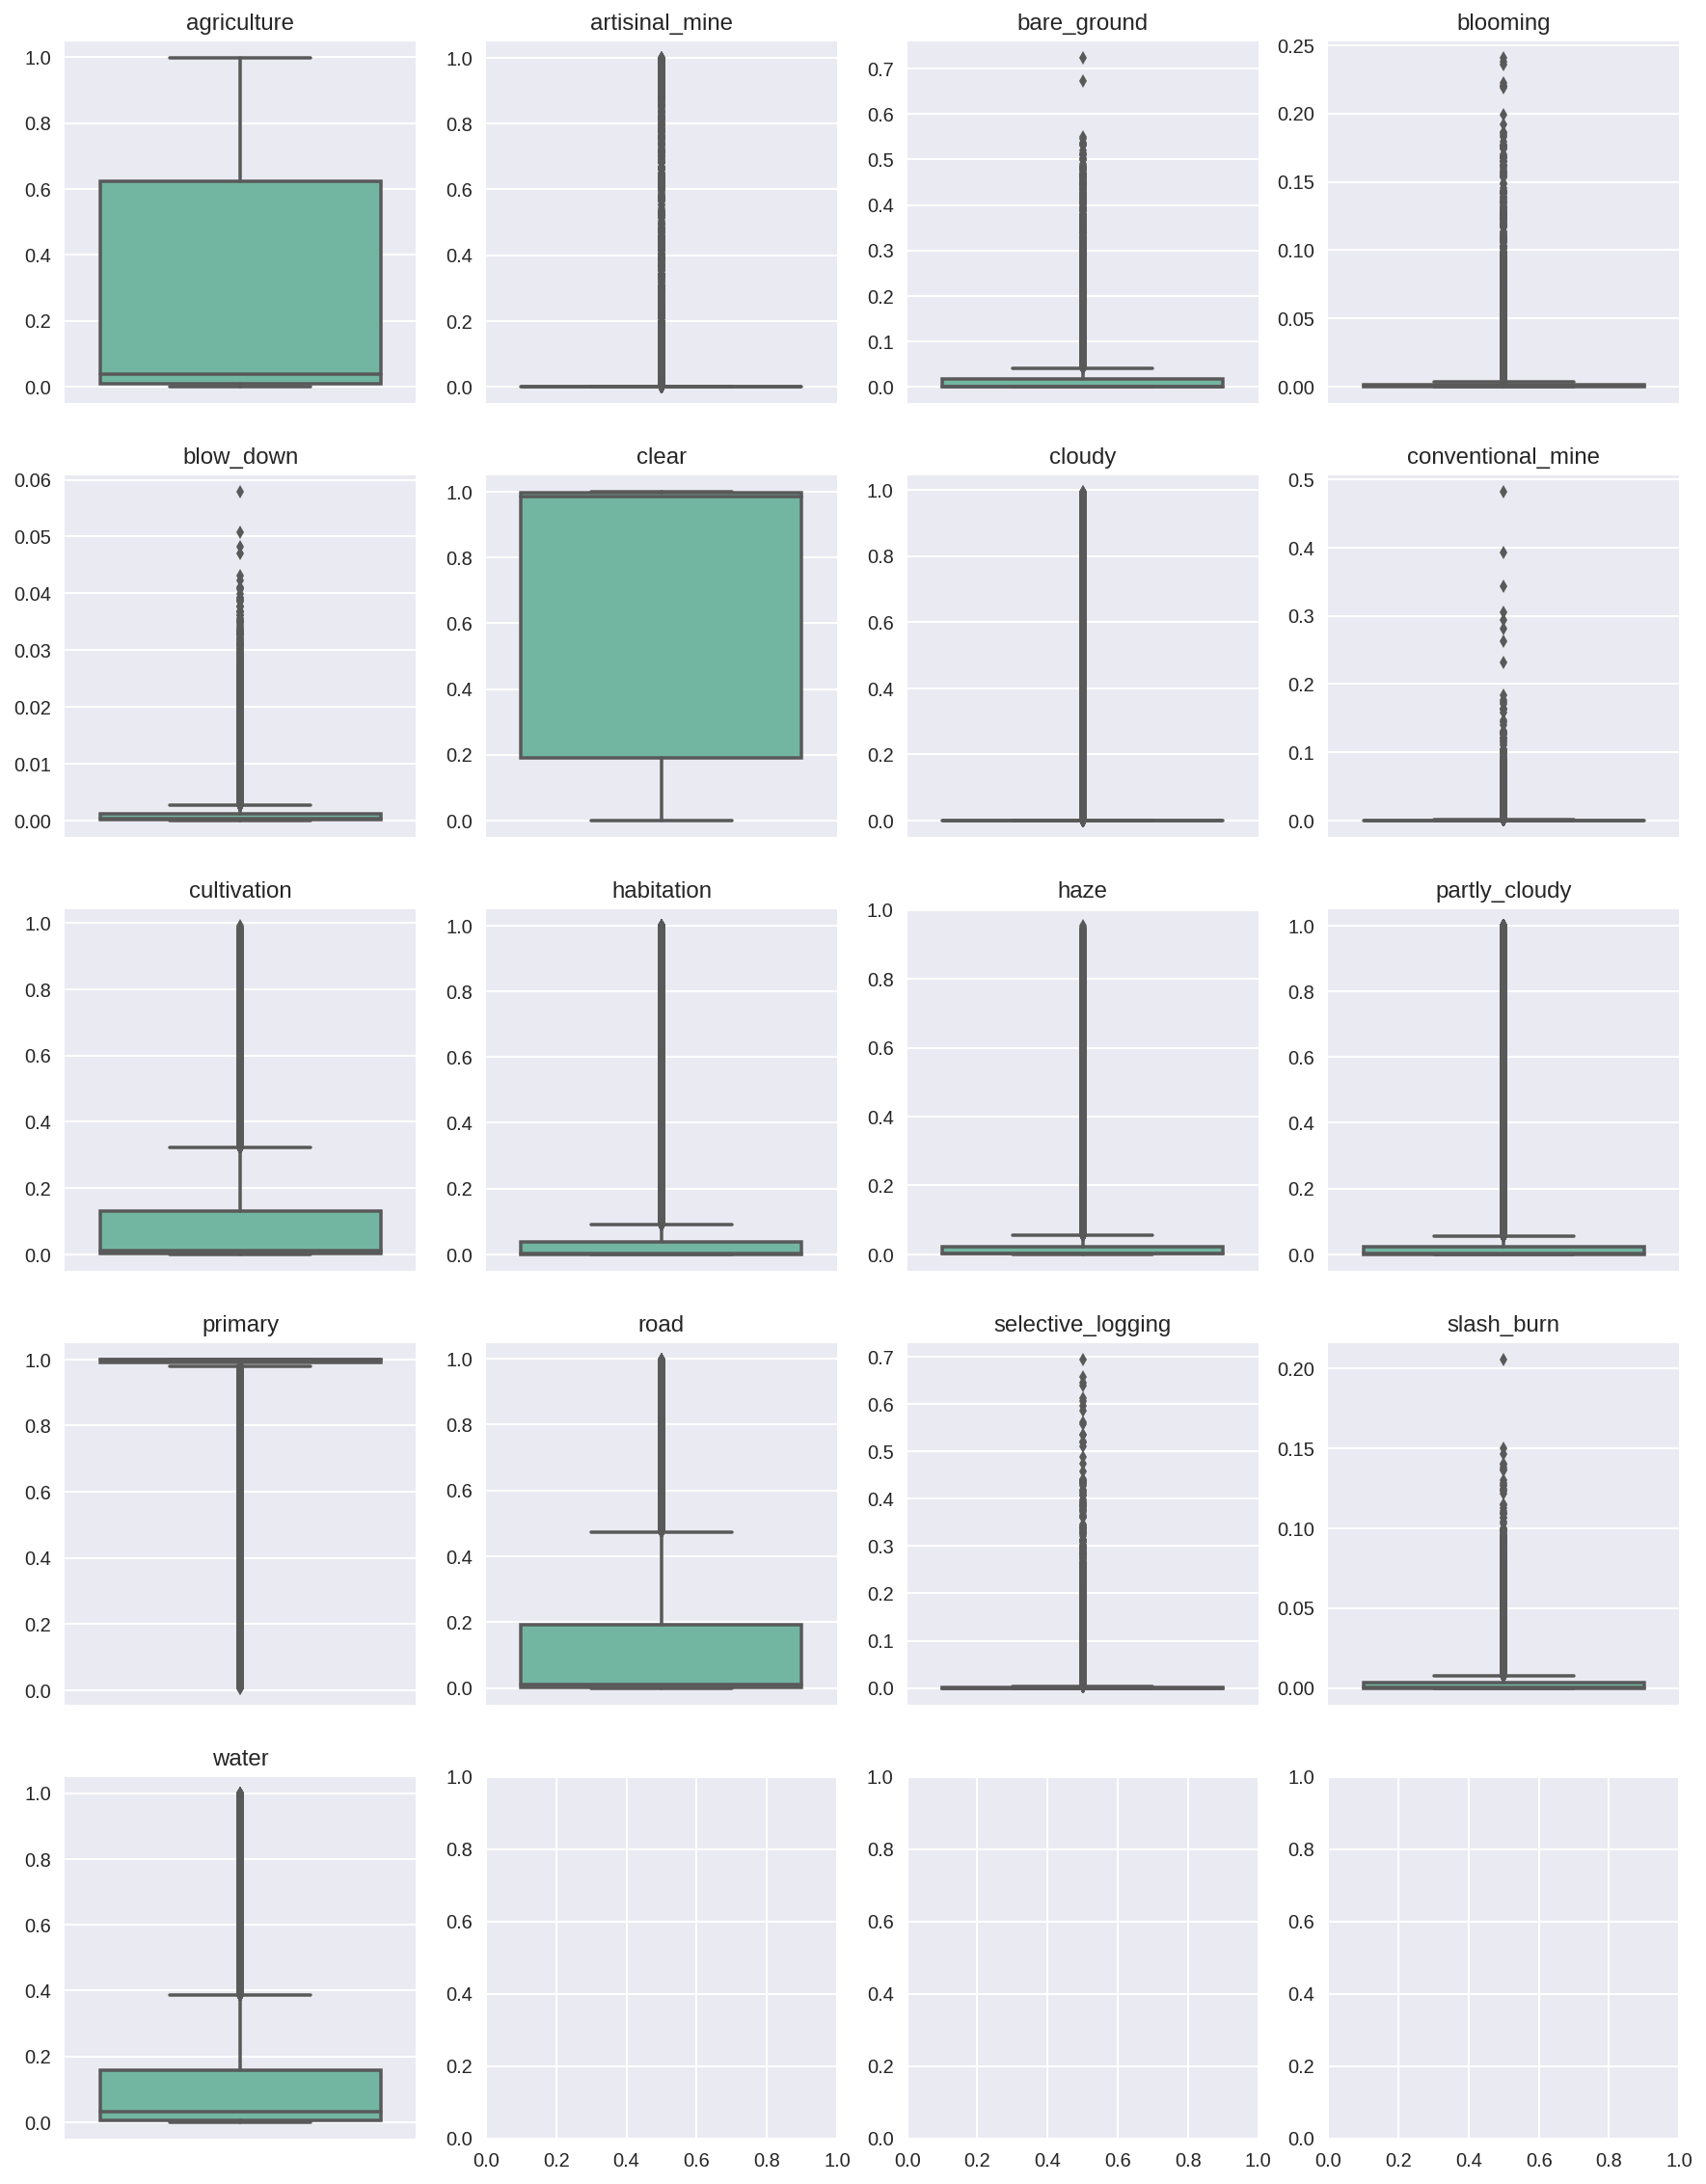

In [11]:
# For now we'll just put all thresholds to 0.2 
thresholds = [0.2] * output_size

# TODO complete
tags_pred = np.array(predictions).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels_map[i])

In [12]:
predicted_labels = model.map_predictions(predictions, labels_map, thresholds)

In [13]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [14]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

,image_name,tags
0,test_22257,clear primary
1,test_30541,agriculture bare_ground clear habitation prima...
2,test_22009,clear primary
3,test_23360,clear primary
4,test_8741,agriculture clear primary road


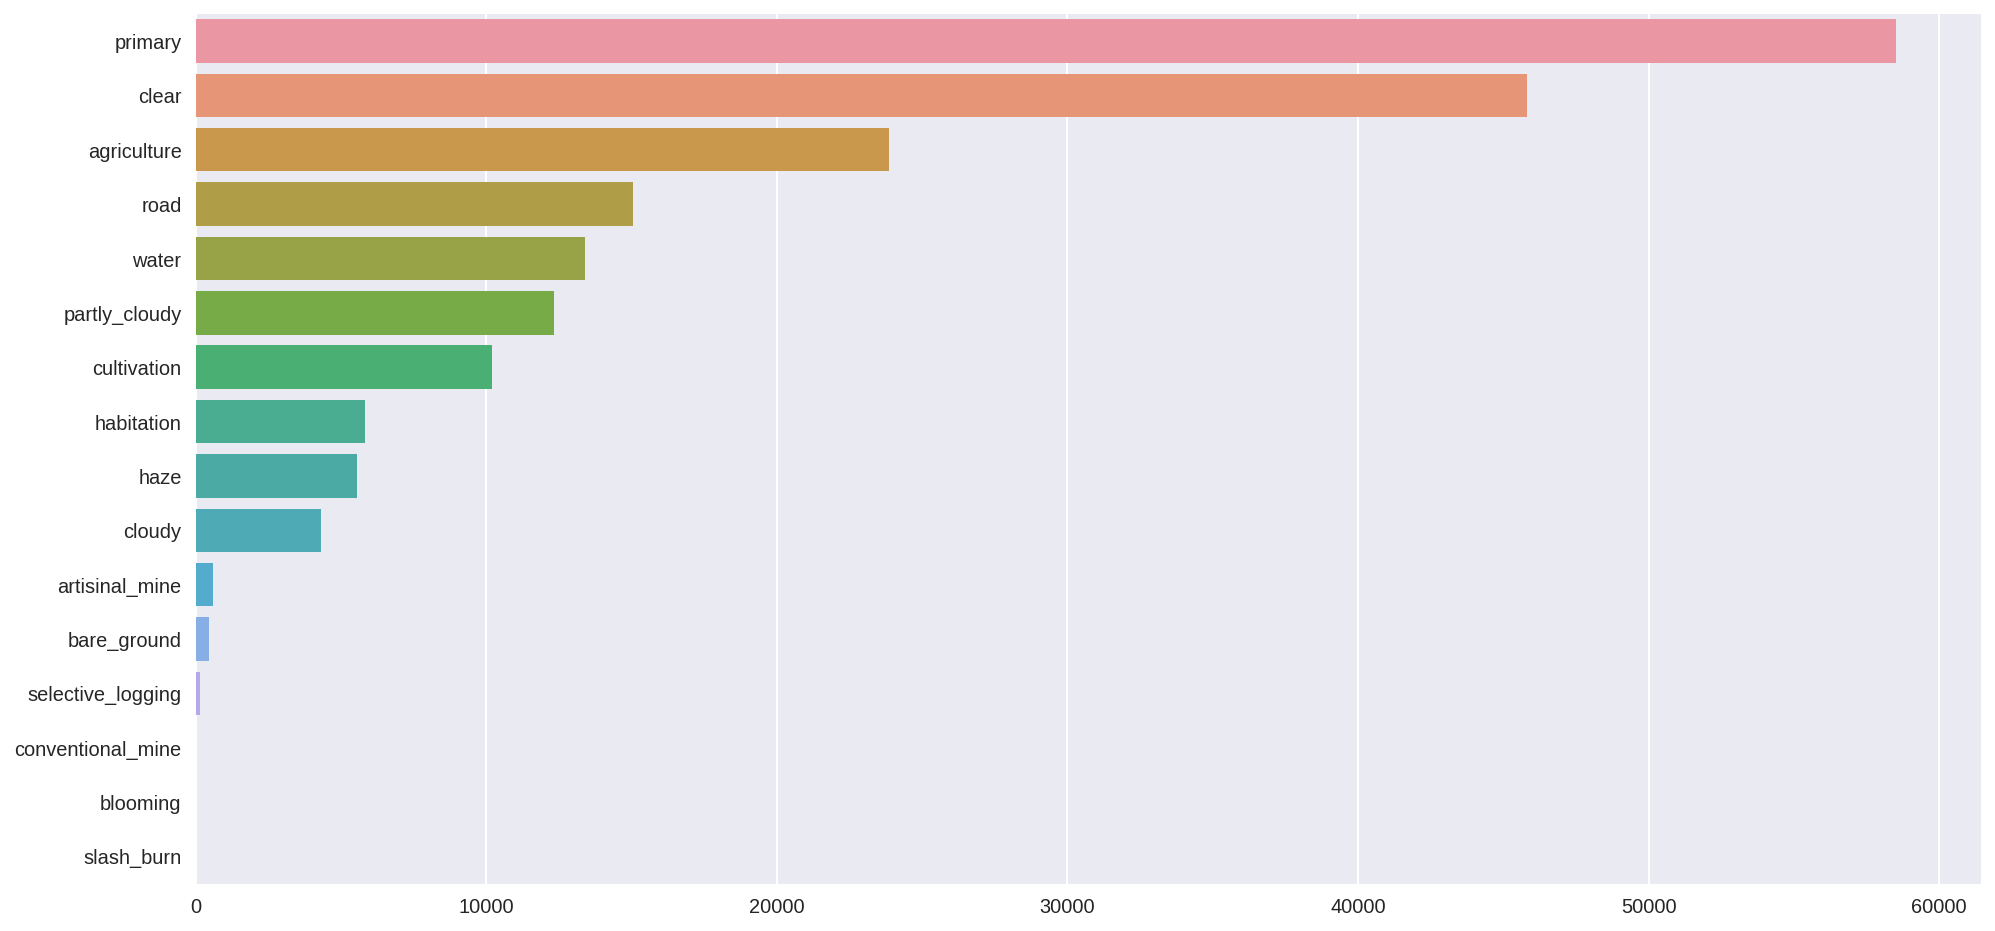

In [15]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [16]:
final_df.to_csv('submission_file.csv', index=False)
model.close()